# Final Project - Modelling student ability over time using Temporal Item Response Theory

We start by evaluating model performance / making sure it works right by fitting the model to a synthetic dataset where the true skill of each student is known. We use the synthetic dataset to compare standard IRT to TIRT.

Once this is done, we fit a TIRT model to a real dataset to perform inference over student ability over time.

Please remember to do all of the following as part of your project:

● Build a statistical model of your scenario.

● Compute posteriors over parameters of interest.

● Make predictions about unobserved data.

● Summarize, interpret, and report your results.

In [16]:
import numpy as np
import pandas as pd
import pandas_profiling as pp

def sigmoid(x):
    return 1 / (1 + np.exp(x))

In [97]:
# volatility of student skill / day.
gamma = 0.1

n_students = 50
n_exercises = 5
n_days = 100
exercise_difficulties = [np.random.randn() for _ in range(n_exercises)]

data = []
for student in range(n_students):
    skill = np.random.randn()
    for t in range(n_days):
        exercise = np.random.randint(0, n_exercises)
        difficulty = exercise_difficulties[exercise]
        p = sigmoid(skill - difficulty)
        outcome = int(np.random.rand() < p)
        data.append(
            {
                'student': student+1,
                'day': t+1,
                'skill': skill,
                'difficulty': difficulty,
                'exercise': exercise+1,
                'outcome': outcome,
                'day_delta': 1
            }
        )
        skill += gamma*np.random.randn()
        
df = pd.DataFrame(data)

In [48]:
df

,student,day,skill,difficulty,exercise,outcome,day_delta
0,1,1,1.411419,1.019073,4,1,1
1,1,2,1.436412,-0.540292,1,0,1
2,1,3,1.461164,1.864996,3,0,1
3,1,4,1.485281,-1.798502,2,0,1
4,1,5,1.549098,-0.540292,1,0,1
5,1,6,1.665491,-0.540292,1,0,1
6,1,7,1.613614,-1.798502,2,0,1
7,1,8,1.529275,-1.189067,0,1,1
8,1,9,1.659190,-1.798502,2,0,1
9,1,10,1.692068,-0.540292,1,0,1


In [21]:
students = [s for _, s in df.groupby('student')]

list

In [33]:
import pystan

In [106]:
stan_code = """
data {
  int<lower=1> J;              // number of students
  int<lower=1> K;              // number of questions
  int<lower=1> N;              // number of observations
  int<lower=1,upper=J> jj[N];  // student for observation n
  int<lower=1,upper=K> kk[N];  // question for observation n
  int<lower=0,upper=1> y[N];   // correctness for observation n
}

parameters {
  real alpha[J];      // ability of student j - mean ability
  real beta[K];       // difficulty of question k
}

model {
  alpha ~ normal(0, 2);         // conservative broad prior
  beta ~ normal(0, 2);          // conservative broad prior
  for (n in 1:N) {
    y[n] ~ bernoulli_logit(alpha[jj[n]] - beta[kk[n]]);
    }
}
"""

In [107]:
#Compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6abe31a017d04a046b0a01c96a875354 NOW.


In [108]:
data = {
  "J": n_students,        # number of students
  "K": n_exercises,       # number of questions
  "N": df.shape[0],       # number of observations
  "jj": df["student"],    # student for observations
  "kk": df["exercise"],   # question for observations
  "y": df["outcome"]      # correctness for observations
}

In [109]:
#Sample posterior distribution over lambda
stan_results = stan_model.sampling(data = data)

In [110]:
print(stan_results.stansummary(pars=['alpha', "beta"], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_6abe31a017d04a046b0a01c96a875354.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1]    2.05    0.03   0.44   1.19   2.04   2.98    300   1.01
alpha[2]    0.09    0.03   0.34  -0.54   0.09   0.75    145   1.01
alpha[3]   -0.49    0.03   0.34  -1.12  -0.49   0.19    153   1.01
alpha[4]   -0.21    0.03   0.34  -0.86  -0.21   0.44    141   1.01
alpha[5]    1.57    0.03    0.4   0.81   1.58   2.38    204   1.01
alpha[6]   -0.48    0.03   0.33  -1.13  -0.48    0.2    148   1.01
alpha[7]   -0.42    0.03   0.34  -1.07  -0.42   0.23    144   1.01
alpha[8]   -0.91    0.03   0.34  -1.57  -0.91  -0.25    149   1.01
alpha[9]    -1.9    0.03   0.37  -2.64  -1.89  -1.19    174   1.01
alpha[10]   0.95    0.03   0.36   0.27   0.94   1.66    168   1.01
alpha[11]   0.32    0.03   0.34  -0.34   0.32   0.98    152   1.01
alpha[1

In [111]:
samples = stan_results.extract()

mean_absolute_error: 1.0828417728395425


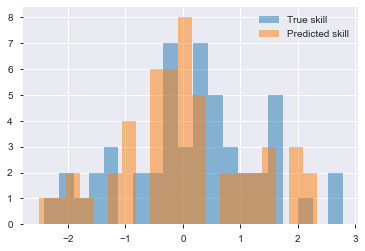

In [122]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline  

true_mean_skill = [df["skill"].loc[df["student"]==i].mean() for i in df["student"].unique()]
pred_mean_skill = [np.mean(samples["alpha"][:,i]) for i in range(samples["alpha"].shape[1])]

mean_absolute_error = mean_absolute_error(mean_skill, pred_mean_skill)
print("mean_absolute_error:", mean_absolute_error)

plt.hist(true_mean_skill, alpha=0.5, label="True skill", bins=20)
plt.hist(pred_mean_skill, alpha=0.5, label="Predicted skill",  bins=20)
plt.legend(loc=0)
plt.show()

In [127]:
from pprint import pprint
pprint(samples["alpha"])

array([[ 1.66572114,  0.10284477, -0.92870477, ...,  0.86206086,
        -0.6385774 , -0.55189493],
       [ 1.9957695 ,  0.24256375, -0.78504752, ...,  0.79841058,
        -0.51916208, -0.29368307],
       [ 1.93478147, -0.15823379, -0.83432246, ...,  0.96628654,
        -0.36000963, -0.24719233],
       ...,
       [ 1.66913069, -0.45723592, -0.84026805, ...,  0.68374215,
        -0.69764065, -0.55732406],
       [ 1.59957459,  0.24418534, -0.88774654, ...,  0.93458137,
        -0.60543155, -0.37082799],
       [ 2.38849672,  0.35590439, -0.22776263, ...,  1.17909402,
        -0.21850911, -0.1753027 ]])


In [113]:
stan_code = """
data {
  int<lower=1> J;              // number of students
  int<lower=1> K;              // number of questions
  int<lower=1> N;              // number of observations
  int<lower=1,upper=J> jj[N];  // student for observation n
  int<lower=1,upper=K> kk[N];  // question for observation n
  int<lower=0,upper=1> y[N];   // correctness for observation n
}

parameters {
  real alpha[J];      // ability of student j - mean ability
  real beta[K];       // difficulty of question k
}

model {
  alpha ~ std_normal();         // conservative broad prior
  beta ~ std_normal();          // conservative broad prior
  for (n in 1:N) {
    y[n] ~ bernoulli_logit(alpha[jj[n]] - beta[kk[n]]);
    }
}
"""

In [ ]:
#Compile the model
stan_model = pystan.StanModel(model_code=stan_code)

In [ ]:
data = {
  "J": n_students,        # number of students
  "K": n_exercises,       # number of questions
  "N": df.shape[0],       # number of observations
  "jj": df["student"],    # student for observations
  "kk": df["exercise"],   # question for observations
  "y": df["outcome"]      # correctness for observations
}

In [ ]:
samples = stan_results.extract()

Resources:

ASSISTments. (2015). 2015 ASSISTments Skill Builder Data.

    Retieved
    https://sites.google.com/site/assistmentsdata/home/2015-assistments-skill-builder-data
    

Stan Development Team. (2019). Stan User’s Guide V.2.2: 1.11 Item-Response Theory Models. 


    Retrieved
    https://mc-stan.org/docs/2_20/stan-users-guide/item-response-models-section.html

In [130]:
len(set(["a", "b", "c", "a", "b"]))

3